In [1]:
import torch.nn.functional as F

In [2]:

import os
import os.path as osp
import numpy as np
import random
#import matplotlib.pyplot as plt
import collections
import torch
import torchvision
import cv2
from torch.utils import data

from PIL import Image


In [3]:
import argparse

import torch
import torch.nn as nn
from torch.utils import data
import numpy as np
import pickle
import cv2
from torch.autograd import Variable
import torch.optim as optim
import scipy.misc
import torch.backends.cudnn as cudnn
import sys
import os
import os.path as osp
from deeplab.model import Res_Deeplab
from deeplab.loss import CrossEntropy2d
from deeplab.datasets import VOCDataSet
from deeplab.datasets import GenericDataset

import torchvision.transforms as transforms
from torchvision.transforms import *
import torch.nn.functional as F


In [4]:

class GenericDataset(data.Dataset):
    def __init__(self, base_path, mode, transforms):
        self.transforms = transforms
        self.mode = mode
        self.base_path = base_path
        self.train_images = os.listdir(osp.join(base_path, 'train','images'))
        self.train_masks= os.listdir(osp.join(base_path, 'train','masks'))
        self.val_images = os.listdir(osp.join(base_path, 'val','images'))
        self.val_masks = os.listdir(osp.join(base_path, 'val','masks'))

    def __len__(self):
        if self.mode == 'train':
            return len(self.train_images)

        return len(self.val_images)

    def __getitem__(self, index):
        if self.mode == 'train':
            img = Image.open(osp.join(self.base_path, 'train','images',self.train_images[index]))
            mask = Image.open(osp.join(self.base_path, 'train','masks',self.train_masks[index])).convert('L')
            return self.transforms(img),self.transforms(mask),img.size,self.train_images[index]

        img = Image.open(osp.join(self.base_path,'val','images',self.val_images[index]))
        mask = Image.open(osp.join(self.base_path,'val','masks',self.val_masks[index])).convert('L')
        return self.transforms(img),self.transforms(mask),img.size, self.val_images[index]


In [5]:
tsize=321

rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)
# todo add augmentation
train_transform = Compose([
#                           transforms.RandomRotation(30),
#                           RandomGamma(0.4, [0.8, 1.2]),
#                          RandomScale(0.4, [0.5, 0.8, 1.5, 2.0]),
#                           RandomCompression(0.4, [70, 90]),
                           #RandomCrop(224),
                           Resize((tsize, tsize)),
                          ToTensor(),
#                           Normalize(rgb_mean, rgb_std)
                           ])


In [6]:
BATCH_SIZE = 8
DATA_DIRECTORY = '/home/dhc/nevus_masks/'
DATA_LIST_PATH = './dataset/list/train_aug.txt'
IGNORE_LABEL = 255
INPUT_SIZE = '321,321'
LEARNING_RATE = 2.5e-4
MOMENTUM = 0.9
NUM_CLASSES = 1
NUM_STEPS = 20000
POWER = 0.9
RANDOM_SEED = 1234
RESTORE_FROM = './dataset/MS_DeepLab_resnet_pretrained_COCO_init.pth'
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 1000
SNAPSHOT_DIR = './snapshots/'
WEIGHT_DECAY = 0.0005


In [7]:
def get_1x_lr_params_NOscale(model):
    """
    This generator returns all the parameters of the net except for 
    the last classification layer. Note that for each batchnorm layer, 
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return 
    any batchnorm parameter
    """
    b = []

    b.append(model.conv1)
    b.append(model.bn1)
    b.append(model.layer1)
    b.append(model.layer2)
    b.append(model.layer3)
    b.append(model.layer4)

    
    for i in range(len(b)):
        for j in b[i].modules():
            jj = 0
            for k in j.parameters():
                jj+=1
                if k.requires_grad:
                    yield k


In [8]:
def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last layer of the net,
    which does the classification of pixel into classes
    """
    b = []
    b.append(model.layer5.parameters())

    for j in range(len(b)):
        for i in b[j]:
            yield i


In [9]:
def adjust_learning_rate(optimizer, i_iter):
    """Sets the learning rate to the initial LR divided by 5 at 60th, 120th and 160th epochs"""
    lr = lr_poly(1e-4, i_iter, 20000, 5)
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = lr * 10



In [10]:

def lr_poly(base_lr, iter, max_iter, power):
    return base_lr*((1-float(iter)/max_iter)**(power))


In [11]:
def loss_calc(pred, label):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    #print(str(pred), str(label))
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    label = Variable(label.long()).cuda()
    #criterion = torch.nn.BCELoss().cuda(gpu)
    criterion = CrossEntropy2d().cuda()
    #criterion = nn.CrossEntropyLoss().cuda(gpu)
    
    #return cross_entropy2d(pred.view(8,1,321,321), label.view(8,1,321,321))
    return criterion(pred, label)


In [12]:
model = Res_Deeplab(num_classes=2)
model.train()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
   

In [13]:
num_classes=2

In [14]:
saved_state_dict = torch.load('snapshots/VOC12_scenes_400.pth')
new_params = model.state_dict().copy()
#for i in saved_state_dict:
    #Scale.layer5.conv2d_list.3.weight
#    i_parts = i.split('.')
    # print i_parts
#    if not num_classes == 21 or not i_parts[1]=='layer5':
#        new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
model.load_state_dict(new_params)


In [14]:
dataset = GenericDataset(DATA_DIRECTORY,'train', train_transform)
trainloader = data.DataLoader(dataset, batch_size = 8, shuffle=True, num_workers = 4, pin_memory=True)

In [15]:
optimizer = optim.SGD([{'params': get_1x_lr_params_NOscale(model), 'lr': 1e-4 }, 
                       {'params': get_10x_lr_params(model), 'lr': 10*1e-4}], 
                      lr=1e-4, momentum=0.9,weight_decay=0.00001)
#    optimizer = optim.Adam(get_10x_lr_params(model), lr=1e-5)
optimizer.zero_grad()


In [16]:
input_size = 321,321

In [17]:
interp = nn.Upsample(size=input_size, mode='bilinear')

In [18]:
topil = ToPILImage()

In [19]:
import matplotlib.pyplot as plt

In [20]:
batch = next(iter(trainloader))

In [21]:
imgs, labels ,_,_ = batch

In [22]:
imgs = Variable(imgs).cuda()

In [23]:
t = model(imgs)

In [24]:
t.size()

torch.Size([8, 2, 41, 41])

In [25]:
t = interp(t)

In [27]:
sigm_t = F.sigmoid(t)

In [28]:
simg_t_l1 = sigm_t[:,1]

In [29]:
labels[0].size()

torch.Size([1, 321, 321])

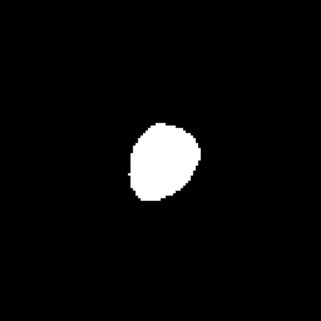

In [30]:
topil(labels[0])

In [29]:
sigm_t_l1_cpu = simg_t_l1.cpu().data

In [30]:
sigm_t_l1_cpu_np = sigm_t_l1_cpu[0].round().numpy()

In [35]:
sigm_t_l1_cpu.shape

torch.Size([8, 321, 321])

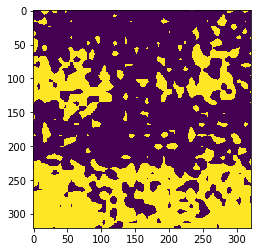

In [31]:
plt.imshow(sigm_t_l1_cpu_np)
plt.show()

In [44]:
tvc = t.cpu().data

In [45]:
tvc.size()

torch.Size([8, 2, 321, 321])

In [41]:
tvc.size()

torch.Size([8, 2, 41, 41])

In [31]:
topil(torch.LongTensor(tvc))

TypeError: torch.LongTensor constructor received an invalid combination of arguments - got (torch.FloatTensor), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.FloatTensor[0m)
 * (torch.LongTensor viewed_tensor)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.FloatTensor[0m)
 * (torch.Size size)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.FloatTensor[0m)
 * (torch.LongStorage data)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.FloatTensor[0m)
 * (Sequence data)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.FloatTensor[0m)


In [16]:
for i_iter, batch in enumerate(trainloader):
    images, labels, _, _ = batch
    images = Variable(images).cuda()

    optimizer.zero_grad()
    adjust_learning_rate(optimizer, i_iter)
    pred = interp(model(images))
    #pred = pred.sum(1)
    loss = loss_calc(pred, labels.squeeze())
    loss.backward()
    optimizer.step()

    print('iter = ', i_iter, 'of', 20000,'completed, loss = ', loss.data.cpu().numpy())

    if i_iter >= 19999:
        print('save model ...')
        torch.save(model.state_dict(),osp.join('snapshots', 'VOC12_scenes_'+str(20000)+'.pth'))
#            break

    if i_iter % 200 == 0 and i_iter!=0:
        print('taking snapshot ...')
        torch.save(model.state_dict(),osp.join('snapshots', 'VOC12_scenes_'+str(i_iter)+'.pth'))     

end = timeit.default_timer()
print(end-start,'seconds')


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generated/../THCReduceAll.cuh:339